In [ ]:
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
import torchvision.models as models
from torchvision import transforms
import torch.optim as optim
from torchvision.datasets import CIFAR10
from torch.optim import lr_scheduler
from PIL import Image
import cv2
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import random
from google.colab.patches import cv2_imshow

#import mlflow

In [ ]:
class ChangeBackground():
    def __init__(self, path_background):
         background_names = os.listdir(path_background)
         self.background_list = []

         for background in background_names:
           background_path = os.path.join(path_background, background)
           self.background_list.append(background_path)


         self.num_imgs = len(self.background_list)

         self.lower_green = (30, 70, 70)
         self.upper_green = (90, 255, 255)



    def __call__(self, img):

        number = random.randint(0, self.num_imgs)

        img = np.array(img)

        if number != self.num_imgs:
          hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)

          green_background = cv2.inRange(hsv, self.lower_green, self.upper_green)
          not_green = cv2.bitwise_not(green_background)

          bg = cv2.imread(self.background_list[number])
          bg = cv2.resize(bg, (img.shape[1], img.shape[0]))

          result = cv2.bitwise_and(img, img, mask = not_green)
          result2 = cv2.bitwise_or(result, bg, mask = green_background)
          changed_image = cv2.add(result, result2)


          changed_image = cv2.cvtColor(changed_image, cv2.COLOR_BGR2RGB)
          changed_image = Image.fromarray(changed_image)

          return changed_image
        else:

          img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
          img = Image.fromarray(img)

          return img

In [ ]:
label_to_index = {3: 0, 4: 1, 5: 2, 6: 3, 7: 4}

Primeiro, bora dar uma olhada nos nossos conjuntos de dados para treino e teste.

Lembrando que, estamos usando 75% para treino e 25% para teste.

In [ ]:
# data_csv = '/content/drive/MyDrive/Water Level Identification/River/classification/river_all_samples_balanceado.csv'

# df = pd.read_csv(data_csv)


# labels = df['label'].unique().tolist()

# print(labels)

# count = df['label'].value_counts()

# print(count)

In [ ]:
# from sklearn.model_selection import train_test_split

# classes = df['label'].unique()
# num_classes = len(classes)

# print('Classes: ', classes)
# print('Num de classes: ',num_classes)

# X_train, X_test, y_train, y_test = train_test_split(df['id'], df['label'], test_size=0.15, stratify=df['label'])

# print("Tamanho conjunto de treino: ", len(X_train))
# print("Tamanho conjunto de teste: ", len(X_test))

# n_train_per_class = max(1, int(len(X_train) / num_classes))
# n_test_per_class = max(1, int(len(X_test) / num_classes))

# print(X_test.tolist())
# print(y_test.tolist())

# def create_csv_from_list(images, labels, mode):
#   data = {'id': images, 'label': labels}

#   df = pd.DataFrame(data)

#   print(mode)
#   print(df)

#   df.to_csv( str(mode) + '.csv' , index = False)


# create_csv_from_list(X_test, y_test, 'test')
# create_csv_from_list(X_train, y_train, 'train')

In [ ]:
# def plot_label_quantidade(csv_file):
#     df = pd.read_csv(csv_file)

#     label_counts = df['label'].value_counts()

#     plt.figure(figsize=(10, 6))
#     label_counts.plot(kind='bar')
#     plt.xlabel('Label')
#     plt.ylabel('Quantidade')
#     plt.title('Rótulo por Quantidade')
#     plt.xticks(rotation=0)
#     plt.show()

In [ ]:
# plot_label_quantidade('/content/train.csv')

In [ ]:
# plot_label_quantidade('/content/test.csv')

Agora, vamos criar nossos datasets de treino e teste e visualizar alguns samples

In [ ]:
class WaterLevelDataset(Dataset):
    def __init__(self, csv_file, images_root, label_to_index, transform=None):
        self.data = pd.read_csv(csv_file)
        self.images_root = images_root
        self.transform = transform
        self.label_to_index = label_to_index

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image_path = os.path.join(self.images_root, self.data.iloc[idx, 0])

        image = Image.open(image_path)

        label = self.data.iloc[idx, 1]
        label = self.label_to_index[label]

        if self.transform:
            image = self.transform(image)

        return image, label

In [ ]:
train_transform = transforms.Compose([
    transforms.Resize(456),
    #ChangeBackground('/content/drive/MyDrive/Water Level Identification/Backgrounds'),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(degrees=(-30, 30)),
    transforms.ToTensor(),
    #transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])


test_transform = transforms.Compose([
    transforms.Resize(456),
    #ChangeBackground('/content/drive/MyDrive/Water Level Identification/Backgrounds'),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(degrees=(-30, 30)),
    transforms.ToTensor(),
    #transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])


images_root = '/content/drive/MyDrive/Water Level Identification/River/Images River'

train_dataset = WaterLevelDataset('/content/drive/MyDrive/Water Level Identification/River/classification/train.csv', images_root, label_to_index, transform = train_transform)
train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True, pin_memory=True)


test_dataset = WaterLevelDataset('/content/drive/MyDrive/Water Level Identification/River/classification/test.csv', images_root, label_to_index, transform = test_transform)
test_dataloader = DataLoader(test_dataset, batch_size=4, shuffle=True, pin_memory=True)

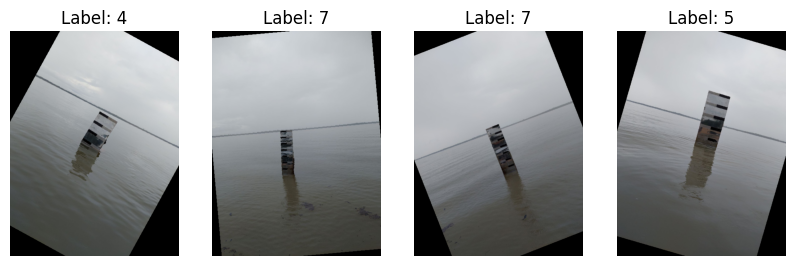

In [ ]:
for i, (images, labels) in enumerate(train_dataloader):
    if i < 1:
        plt.figure(figsize=(10, 5))
        for j in range(images.shape[0]):
            plt.subplot(1, images.shape[0], j + 1)
            plt.imshow(images[j].permute(1, 2, 0))
            plt.title(f"Label: {labels[j]+3}")
            plt.axis('off')
        plt.show()

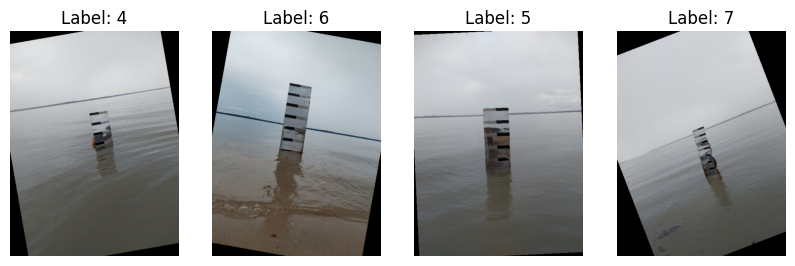

In [ ]:
for i, (images, labels) in enumerate(test_dataloader):
    if i < 1:
        plt.figure(figsize=(10, 5))
        for j in range(images.shape[0]):
            plt.subplot(1, images.shape[0], j + 1)
            plt.imshow(images[j].permute(1, 2, 0))
            plt.title(f"Label: {labels[j]+3}")
            plt.axis('off')
        plt.show()

In [ ]:
num_epochs = 50
learning_rate = 0.001

In [ ]:
model = models.resnet18(pretrained=True)
num_classes = 5


for param in model.parameters():
    param.requires_grad = False


model.fc = nn.Linear(model.fc.in_features, num_classes)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 87.1MB/s]


In [ ]:
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
# from torchvision.models import efficientnet_b4, EfficientNet_B4_Weights
# from torchvision.models._api import WeightsEnum
# from torch.hub import load_state_dict_from_url

# def get_state_dict(self, *args, **kwargs):
#     kwargs.pop("check_hash")
#     return load_state_dict_from_url(self.url, *args, **kwargs)
# WeightsEnum.get_state_dict = get_state_dict

# model = efficientnet_b4(weights=EfficientNet_B4_Weights.IMAGENET1K_V1)

# #efficientnet_b4(weights="DEFAULT")

# num_classes = 5

# for params in model.parameters():
#   params.requires_grad = False

# model.classifier[1] = nn.Linear(in_features=1792, out_features=num_classes)

# print(model)

In [ ]:
from torch.nn.modules.loss import CrossEntropyLoss

criterion = CrossEntropyLoss(label_smoothing = 0.1)


optimizer = optim.Adam(model.parameters(), lr = learning_rate)


scheduler = lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model.to(device)

In [ ]:
def train(model, train_loader, optimizer, criterion, device):
    model.train()
    total_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)


        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    accuracy = 100 * correct / total
    return total_loss, accuracy


def evaluate(model, test_loader, criterion, device):
    model.eval()
    total_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)


            outputs = model(inputs)
            loss = criterion(outputs, labels)

            total_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    accuracy = 100 * correct / total
    return total_loss, accuracy

In [ ]:
all_train_losses = []
all_train_acc = []

In [ ]:
all_test_losses = []
all_test_acc = []

In [ ]:
for epoch in range(num_epochs):
            train_loss, train_accuracy = train(model, train_dataloader, optimizer, criterion, device)
            test_loss, test_accuracy = evaluate(model, test_dataloader, criterion, device)

            all_train_losses.append(train_loss)
            all_train_acc.append(train_accuracy)
            all_test_losses.append(test_loss)
            all_test_acc.append(test_accuracy)


            print(f"Epoch {epoch+1}: Train Loss={train_loss:.4f}, Train Accuracy={train_accuracy:.2f}%, "
                  f"Test Loss={test_loss:.4f}, Test Accuracy={test_accuracy:.2f}%")


Epoch 1: Train Loss=12.7790, Train Accuracy=4.00%, Test Loss=3.6666, Test Accuracy=20.00%
Epoch 2: Train Loss=11.0060, Train Accuracy=28.00%, Test Loss=3.2991, Test Accuracy=20.00%
Epoch 3: Train Loss=12.6235, Train Accuracy=20.00%, Test Loss=3.2937, Test Accuracy=40.00%
Epoch 4: Train Loss=11.6494, Train Accuracy=24.00%, Test Loss=3.0613, Test Accuracy=40.00%
Epoch 5: Train Loss=11.8999, Train Accuracy=28.00%, Test Loss=3.6970, Test Accuracy=20.00%
Epoch 6: Train Loss=11.8259, Train Accuracy=20.00%, Test Loss=3.6568, Test Accuracy=20.00%
Epoch 7: Train Loss=11.3028, Train Accuracy=24.00%, Test Loss=3.2878, Test Accuracy=20.00%
Epoch 8: Train Loss=11.7327, Train Accuracy=20.00%, Test Loss=2.7832, Test Accuracy=40.00%
Epoch 9: Train Loss=10.8629, Train Accuracy=32.00%, Test Loss=3.0514, Test Accuracy=40.00%
Epoch 10: Train Loss=11.0521, Train Accuracy=24.00%, Test Loss=3.1075, Test Accuracy=20.00%
Epoch 11: Train Loss=11.2729, Train Accuracy=16.00%, Test Loss=2.7830, Test Accuracy=60.00

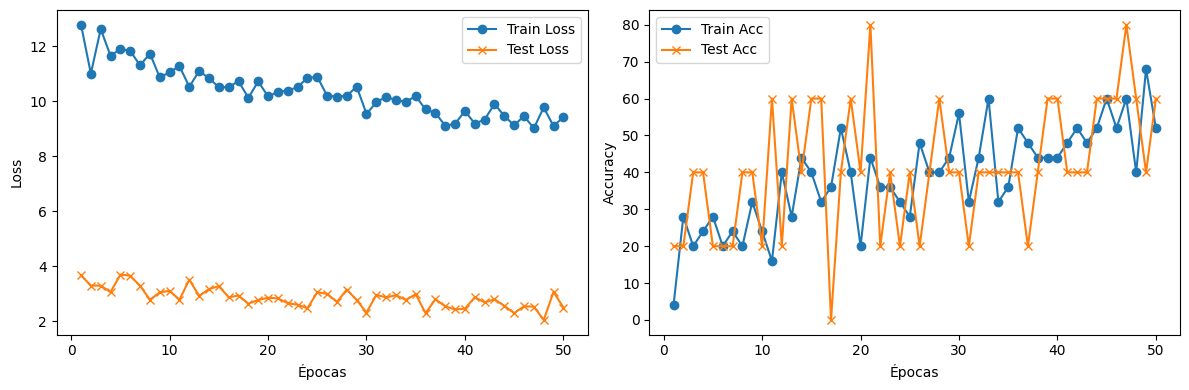

In [ ]:
epochs = list(range(1, num_epochs + 1))


plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, all_train_losses, label='Train Loss', marker='o')
plt.plot(epochs, all_test_losses, label='Test Loss', marker='x')
plt.xlabel('Épocas')
plt.ylabel('Loss')
plt.legend()


plt.subplot(1, 2, 2)
plt.plot(epochs, all_train_acc, label='Train Acc', marker='o')
plt.plot(epochs, all_test_acc, label='Test Acc', marker='x')
plt.xlabel('Épocas')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()